In [ ]:
!git clone https://github.com/CubiCasa/CubiCasa5k

Cloning into 'CubiCasa5k'...
remote: Enumerating objects: 120, done.
remote: Counting objects: 100% (68/68), done.
remote: Compressing objects: 100% (33/33), done.
remote: Total 120 (delta 43), reused 37 (delta 35), pack-reused 52
Receiving objects: 100% (120/120), 62.49 MiB | 2.59 MiB/s, done.
Resolving deltas: 100% (54/54), done.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cd CubiCasa5k/

[Errno 2] No such file or directory: 'CubiCasa5k/'
/content/CubiCasa5k


In [ ]:
!ls

 create_lmdb.py			      eval.py	   requirements.txt
 data				      floortrans   runs_cubi
'Difference in Room Annotation.pdf'   LICENSE	   samples.ipynb
 Dockerfile			      README.md    train.py


In [ ]:
from zipfile import ZipFile
file = "/content/drive/MyDrive/cubicasa5k.zip"
with ZipFile(file, 'r') as zip:
  zip.printdir() 
  
  # extracting all the files 
  print('Extracting all the files now...') 
  zip.extractall()

Streaming output truncated to the last 5000 lines.
cubicasa5k/high_quality_architectural/4014/F1_scaled.png 2018-07-14 14:45:52       518589
cubicasa5k/high_quality_architectural/4014/F1_original.png 2018-07-14 14:45:52       472153
cubicasa5k/high_quality_architectural/4014/model.svg 2019-01-23 15:49:34        71189
cubicasa5k/high_quality_architectural/14296/   2018-12-17 11:05:32            0
cubicasa5k/high_quality_architectural/14296/F1_scaled.png 2018-12-04 21:06:48       751103
cubicasa5k/high_quality_architectural/14296/F1_original.png 2018-12-04 21:06:48       648064
cubicasa5k/high_quality_architectural/14296/model.svg 2019-01-23 15:49:34        62566
cubicasa5k/high_quality_architectural/14295/   2018-12-17 11:05:32            0
cubicasa5k/high_quality_architectural/14295/F2_scaled.png 2018-12-04 21:06:46      1022447
cubicasa5k/high_quality_architectural/14295/F1_scaled.png 2018-12-04 21:06:42      1022447
cubicasa5k/high_quality_architectural/14295/F1_original.png 2018-12-

In [ ]:
!pip install svgpathtools

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.4/67.4 kB 4.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.1/67.1 kB 9.5 MB/s eta 0:00:00


In [ ]:
!pip install lmdb

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 299.2/299.2 kB 14.1 MB/s eta 0:00:00


In [ ]:
import lmdb

In [ ]:
%matplotlib inline
from skimage import transform
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
from floortrans.models import get_model
from floortrans.loaders import FloorplanSVG, DictToTensor, Compose, RotateNTurns
from floortrans.plotting import segmentation_plot, polygons_to_image, draw_junction_from_dict, discrete_cmap
from floortrans.post_prosessing import split_prediction, get_polygons, split_validation
from mpl_toolkits.axes_grid1 import AxesGrid

In [ ]:
rot = RotateNTurns()
room_classes = ["Background", "Outdoor", "Wall", "Kitchen", "Living Room" ,"Bed Room", "Bath", "Entry", "Railing", "Storage", "Garage", "Undefined"]
icon_classes = ["No Icon", "Window", "Door", "Closet", "Electrical Applience" ,"Toilet", "Sink", "Sauna Bench", "Fire Place", "Bathtub", "Chimney"]

In [ ]:
data_folder = '/content/CubiCasa5k/cubicasa5k/'
data_file = 'test.txt'
normal_set = FloorplanSVG(data_folder, data_file, format='txt', original_size=True)
data_loader = DataLoader(normal_set, batch_size=1, num_workers=0)
data_iter = iter(data_loader)

In [ ]:
# Setup Model
model = get_model('hg_furukawa_original', 51)

n_classes = 44
split = [21, 12, 11]
model.conv4_ = torch.nn.Conv2d(256, n_classes, bias=True, kernel_size=1)
model.upsample = torch.nn.ConvTranspose2d(n_classes, n_classes, kernel_size=4, stride=4)
checkpoint = torch.load('/content/drive/MyDrive/mdoel/model_best_val_loss_var.pkl')

model.load_state_dict(checkpoint['model_state'])
model.eval()
model.cuda()
print("Model loaded.")

Model loaded.


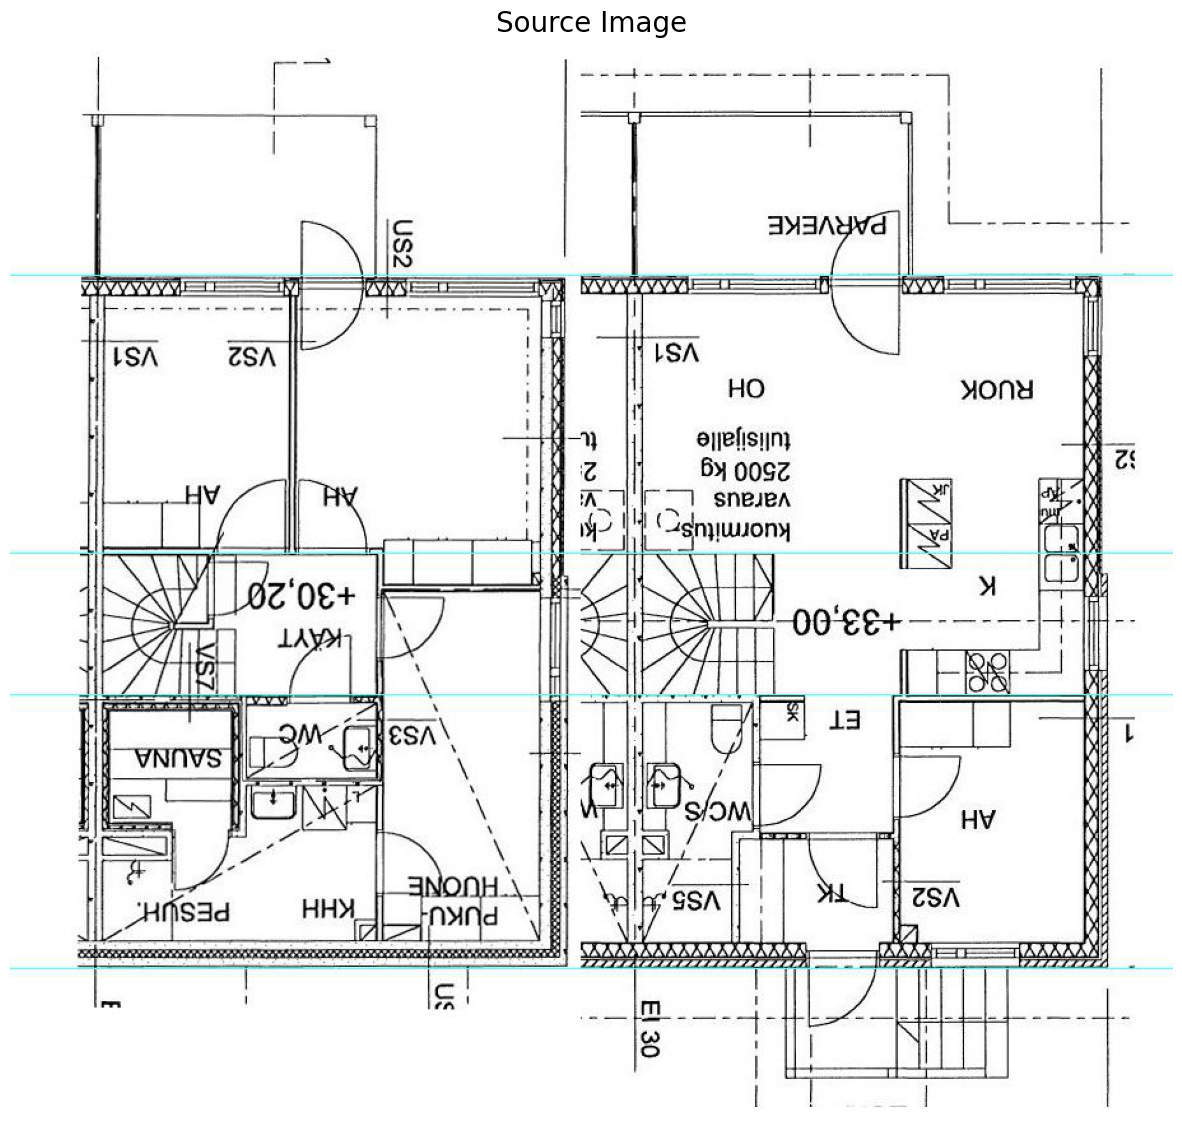

In [ ]:
val = next(data_iter)
junctions = val['heatmaps']
folder = val['folder'][0]
image = val['image'].cuda()
label = val['label']
np_img = np.moveaxis(image[0].cpu().data.numpy(), 0, -1) / 2 + 0.5
plt.figure(figsize=(15,15))
plt.title('Source Image', fontsize=20)
plt.axis('off')
plt.imshow(np_img)
plt.show()

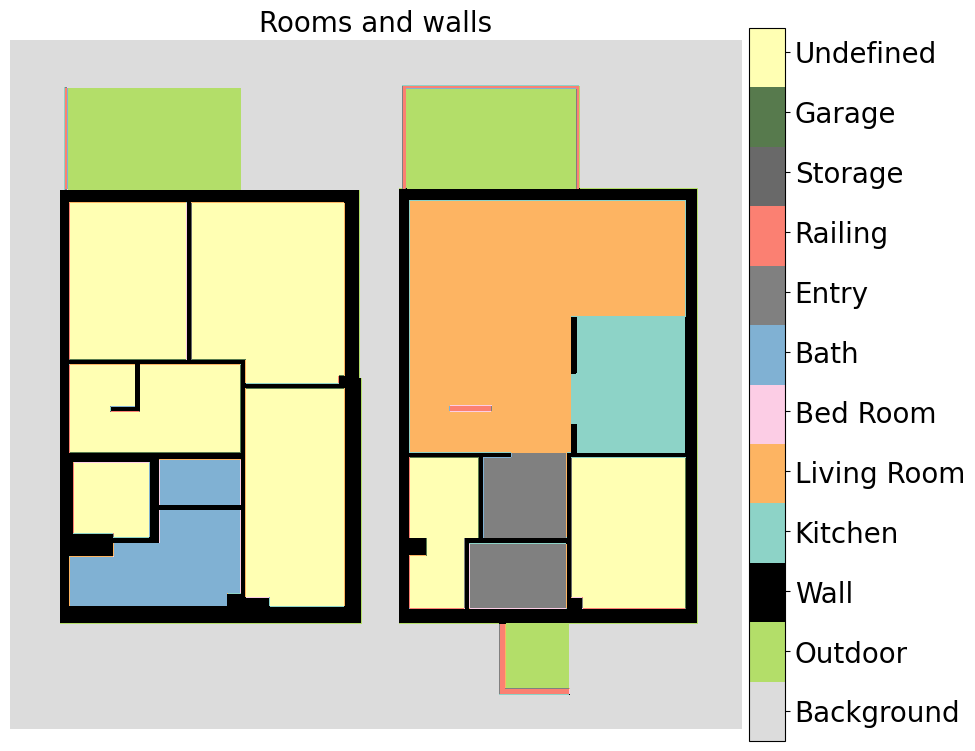

In [ ]:
label_np = label.data.numpy()[0]
plt.figure(figsize=(10,10))
ax = plt.subplot(1, 1, 1)
plt.title('Rooms and walls', fontsize=20)
ax.axis('off')
n_rooms = 12
rseg = ax.imshow(label_np[0],  cmap='rooms', vmin=0, vmax=n_rooms-0.1)
cbar = plt.colorbar(rseg, ticks=np.arange(n_rooms) + 0.5, fraction=0.046, pad=0.01)
cbar.ax.set_yticklabels(room_classes, fontsize=20)
plt.show()

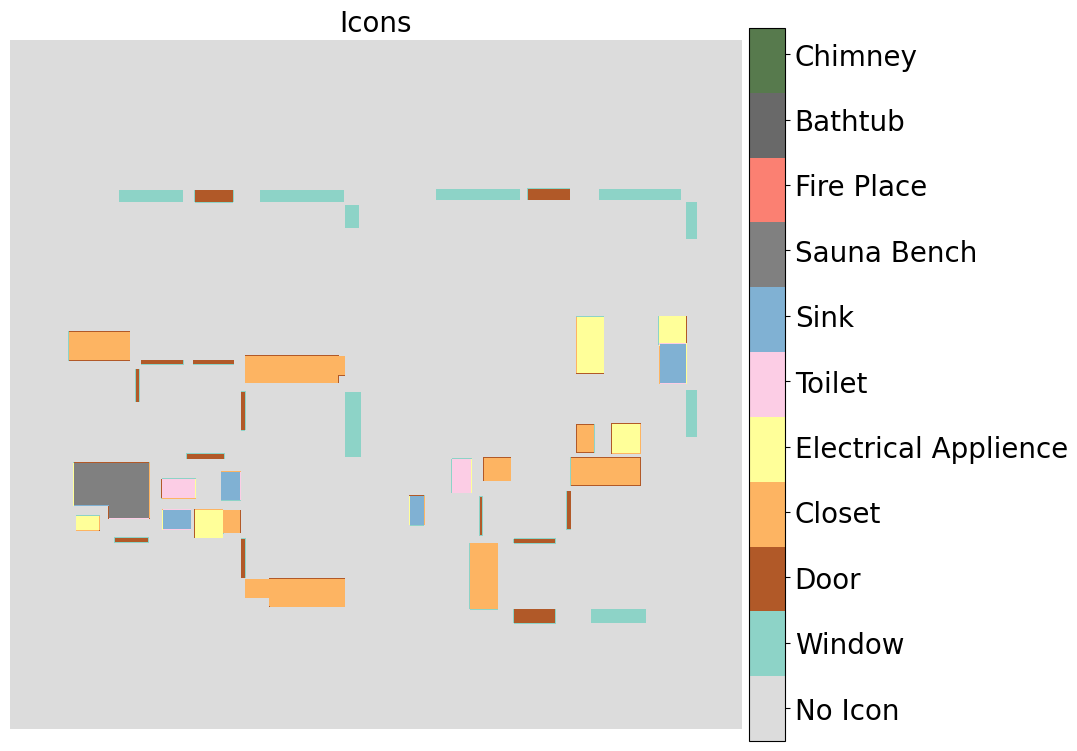

In [ ]:
plt.figure(figsize=(10,10))
ax = plt.subplot(1, 1, 1)
plt.title('Icons', fontsize=20)
ax.axis('off')
n_icons = 11
iseg = ax.imshow(label_np[1], cmap='icons', vmin=0, vmax=n_icons-0.1)
cbar = plt.colorbar(iseg, ticks=np.arange(n_icons) + 0.5, fraction=0.046, pad=0.01)
cbar.ax.set_yticklabels(icon_classes, fontsize=20)
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming you have defined `room_classes` as a list of room labels
room_classes = ["Background", "Outdoor", "Wall", "Kitchen", "Living Room" ,"Bed Room", "Bath", "Entry", "Railing", "Storage", "Garage", "Undefined"]

# Assuming `label` is the labeled segmentation map
label_np = label.data.numpy()[0].astype(int)

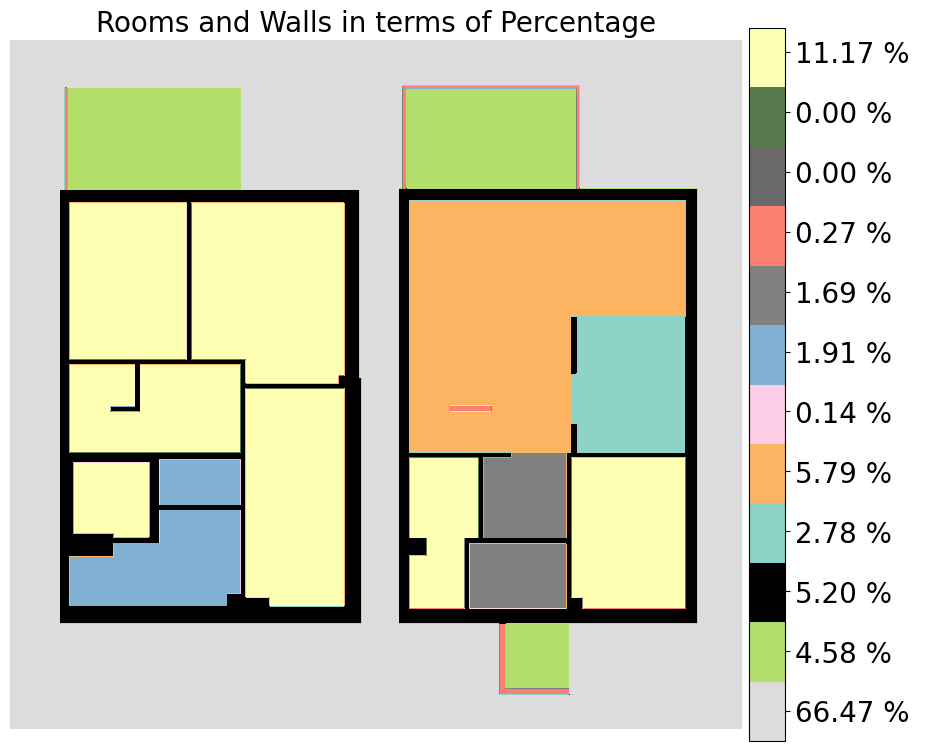

In [ ]:
plt.figure(figsize=(10, 10))
ax = plt.subplot(1, 1, 1)
plt.title('Rooms and Walls in terms of Percentage', fontsize=20)
ax.axis('off')
n_rooms = 12

color_percentages = []
total_pixels = label_np.shape[0] * label_np.shape[1]
for color_index in range(n_rooms):
    color_pixels = np.count_nonzero(label_np == color_index)
    color_percentage = (color_pixels / total_pixels) * 100
    color_percentages.append(round(color_percentage,2))

color_percentages = np.array(color_percentages)
normalized_percentages = color_percentages / np.sum(color_percentages) * 100

rseg = ax.imshow(label_np[0], cmap='rooms', vmin=0, vmax=n_rooms-0.1)
cbar = plt.colorbar(rseg, ticks=np.arange(n_rooms) + 0.5, fraction=0.046, pad=0.01)

# Update colorbar labels with color percentages out of 100
cbar.ax.set_yticklabels(["{:.2f} % ".format(p) for p in normalized_percentages], fontsize=20)


plt.show()

In [ ]:
pip install torch torchvision torchaudio

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
pip install easyocr

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 60.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 813.9/813.9 kB 60.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.6/47.6 MB 17.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 146.0/146.0 kB 12.5 MB/s eta 0:00:00
  Attempting uninstall: opencv-python-headless
    Found existing installation: opencv-python-headless 4.7.0.72
    Uninstalling opencv-python-headless-4.7.0.72:
      Successfully uninstalled opencv-python-headless-4.7.0.72


In [ ]:
pip install git+https://github.com/JaidedAI/EasyOCR.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/JaidedAI/EasyOCR.git to /tmp/pip-req-build-65wiillp
  Running command git clone --filter=blob:none --quiet https://github.com/JaidedAI/EasyOCR.git /tmp/pip-req-build-65wiillp
  Resolved https://github.com/JaidedAI/EasyOCR.git to commit 5c68ae4b3f273500dbcfeb06832415d8704020d1
  Preparing metadata (setup.py) ... done


In [ ]:
import easyocr

In [ ]:
reader = easyocr.Reader(['en'])

Progress: |██████████████████████████████████████████████████| 100.0% Complete

Progress: |██████████████████████████████████████████████████| 100.0% Complete

In [ ]:
result = reader.readtext('/content/source2.png')

In [ ]:
reader.readtext('/content/source2.png', detail = 0)

['VS5',
 'PUKU-',
 'KHH',
 'PESUH;',
 'VS2',
 'TK',
 'HUONE',
 'AH',
 'wcIS',
 'SAUNA',
 'vS3',
 'we',
 'ET',
 'LKAYT',
 '+33,00',
 'K',
 '+30,20',
 'kuormitus ',
 'varaus',
 '%',
 'AH',
 'AH',
 '2500 kg',
 'tulisijalle',
 'tl',
 'RUOK',
 'OH',
 'VST',
 'VS2',
 'VSI',
 'PARVEKE',
 'g']